Phân tích biến động giá cổ phiếu MSN <br>
Người thực hiện: Đỗ Việt Bách <br>
Phone: 0559 686 243 <br>
Email: 19521230@gm.uit.edu.vn <br>
Dataset: Giá trị cổ phiếu MSN từ ngày 25/12/2017 tới ngày 22/12/2020 <br>
Mô hình dự báo: RNN vs. GRU




##Import dữ liệu và thư viện cần thiết

In [1]:
from google.colab import files
uploaded = files.upload()

Saving MSN.csv to MSN.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/MSN.csv')

In [4]:
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0
...,...,...,...,...,...,...,...,...
135349,MSN,12/22/2020 14:23,82.8,82.8,82.8,82.8,700,0
135350,MSN,12/22/2020 14:24,82.7,82.8,82.7,82.8,4660,0
135351,MSN,12/22/2020 14:25,82.8,82.8,82.8,82.8,50,0
135352,MSN,12/22/2020 14:27,82.8,82.8,82.8,82.8,300,0


##Làm sạch dữ liệu

In [5]:
# Xem kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [6]:
df.dtypes

Ticker            object
Date/Time         object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Open Interest      int64
dtype: object

In [7]:
# Kiểm tra hàng trùng lặp
df.duplicated().any()

False

In [8]:
# Kiểm tra Null
df.isnull().any()

Ticker           False
Date/Time        False
Open             False
High             False
Low              False
Close            False
Volume           False
Open Interest    False
dtype: bool

In [9]:
# Kiểm tra các giá trị min, max, mean(giá trị trung bình), standard(độ lệch chuẩn) của mỗi cột
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,135354.000000,135354.000000,135354.000000,135354.000000,1.353540e+05,135354.0
mean,74.878809,74.931668,74.834625,74.880759,5.683578e+03,0.0
std,15.418074,15.426954,15.412677,15.418857,2.798513e+04,0.0
min,46.500000,46.500000,46.400000,46.400000,1.000000e+01,0.0
25%,57.900000,57.900000,57.800000,57.800000,5.000000e+02,0.0
50%,79.100000,79.200000,79.100000,79.100000,2.000000e+03,0.0
75%,86.000000,86.100000,86.000000,86.000000,5.560000e+03,0.0
max,117.800000,118.000000,117.700000,118.000000,3.300680e+06,0.0


In [10]:
import matplotlib.pyplot as plt

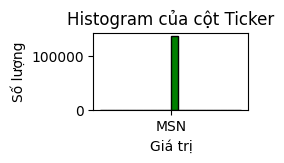

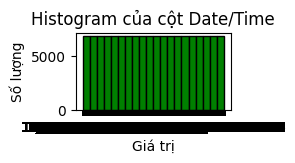

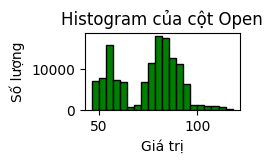

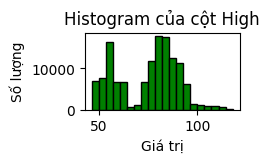

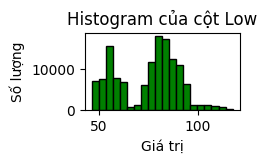

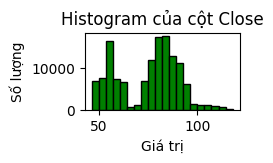

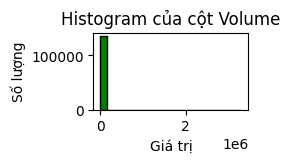

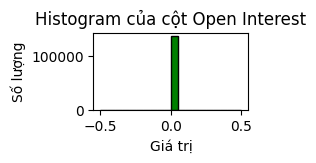

In [11]:
# Sử dụng Histogram để kiểm tra sự phân bổ giá trị trong mỗi cột
for column in df.columns:
    plt.figure(figsize=(2, 1))
    plt.hist(df[column], bins=20, color='green', edgecolor='black')
    plt.title(f'Histogram của cột {column}')
    plt.xlabel('Giá trị')
    plt.ylabel('Số lượng')
    plt.show()

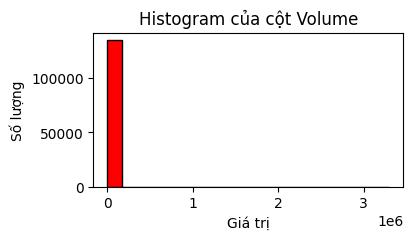

In [12]:
plt.figure(figsize=(4, 2))
plt.hist(df['Volume'], bins=20, color='red', edgecolor='black')
plt.title('Histogram của cột Volume')
plt.xlabel('Giá trị')
plt.ylabel('Số lượng')
plt.show()

### Nhận xét dữ liệu
+ Cột Volume có sự chênh lệch lớn giữa các giá trị, có thể làm dự báo sai lệch.
+ Ở đây bài toán đặt ra là dự báo giá trị cổ phiếu thì em sẽ sử dụng cột Close làm thuộc tính quyết định để dự báo. Do các cột Open, High, Low có sự tương đồng nên loại bỏ để giảm thời gian thực thi.
+ Để tăng Accuracy của thuật toán thì sẽ sử dụng Scale giá trị cột Close bằng công thức: (Giá trị - min)/(max - min)

In [13]:
df1 = df.reset_index()['Close']
df1 = df1.reset_index(drop=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Scale cột Close và lưu vào mảng
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [17]:
df1

array([[0.37290503],
       [0.37150838],
       [0.37849162],
       ...,
       [0.50837989],
       [0.50837989],
       [0.50837989]])

##Phân tích dữ liệu

### Phương pháp sử dụng
- Đề bài là phân tích biến động giá cổ phiếu, ở đây em lựa chọn giá cổ phiếu giờ đóng cửa (Close) để phân tích.
- Đối với tập dữ liệu này có 3 phương pháp phổ biến để phân tích:
  + 1.Phương pháp phân tích chuỗi thời gian (Time Series Analysis): ARIMA, SARIMA ...
  + 2.Phương pháp Machine Learning : Linear Regression, KNN ...
  + 3.Phương pháp Deep Learning
- Với bài toán dự báo xu hướng giá trị em sẽ sử dụng 2 mô hình Recurrent Neural Network (RNN) và mô hình Gated Recurrent Unit (GRU) nằm trong phương pháp Deep Learning. Trong phương pháp này mô hình Long short term memory (LSTM) có Accuracy tốt hơn, nhưng với tập dữ liệu có 135354 dòng thì LSTM có thời gian thực thi lâu hơn rất nhiều do sử dụng nhiều tham số.

In [18]:
# Chia dữ liệu thành 3 phần Train, Test, Validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [19]:
train_data

array([[0.37290503],
       [0.37150838],
       [0.37849162],
       ...,
       [0.03282123],
       [0.03282123],
       [0.03282123]])

In [20]:
test_data

array([[0.03282123],
       [0.03282123],
       [0.03282123],
       ...,
       [0.10963687],
       [0.10963687],
       [0.11103352]])

In [21]:
val_data

array([[0.11103352],
       [0.11103352],
       [0.11243017],
       ...,
       [0.50837989],
       [0.50837989],
       [0.50837989]])

### Mô hình RNN

In [22]:
# Gọi các thư viện cần thiết để xây dựng RNN
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [23]:
train_data_RNN = train_data
test_data_RNN = test_data
val_data_RNN = val_data

In [24]:
# Hàm Create Dataset để chuyển đổi mảng thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [25]:
# Sử dụng hàm Create Dataset để chuyển đổi các mảng Train, Test, Validate
time_step = 100
x_train_RNN, y_train_RNN = create_dataset(train_data_RNN, time_step)
x_val_RNN, y_val_RNN = create_dataset(val_data_RNN, time_step)
x_test_RNN, y_test_RNN = create_dataset(test_data_RNN, time_step)

In [26]:
# Reshape đầu vào để phù hợp với mô hình RNN
x_train_RNN = x_train_RNN.reshape(x_train_RNN.shape[0], x_train_RNN.shape[1], 1)
x_test_RNN = x_test_RNN.reshape(x_test_RNN.shape[0], x_test_RNN.shape[1], 1)
x_val_RNN = x_val_RNN.reshape(x_val_RNN.shape[0], x_val_RNN.shape[1], 1)

In [27]:
# Khai báo mô hình RNN
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
# Fit mô hình với dữ liệu Train
model.fit(x_train_RNN, y_train_RNN , validation_data = (x_test_RNN, y_test_RNN),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
1479/1479 [==============================] - 32s 21ms/step - loss: 1.2571e-04 - val_loss: 7.1997e-06
Epoch 2/100
1479/1479 [==============================] - 31s 21ms/step - loss: 1.6150e-05 - val_loss: 5.0725e-06
Epoch 3/100
1479/1479 [==============================] - 31s 21ms/step - loss: 1.3661e-05 - val_loss: 5.0482e-06
Epoch 4/100
1479/1479 [==============================] - 29s 20ms/step - loss: 1.2018e-05 - val_loss: 4.7094e-06
Epoch 5/100
1479/1479 [==============================] - 29s 20ms/step - loss: 1.1552e-05 - val_loss: 3.9731e-06
Epoch 6/100
1479/1479 [==============================] - 32s 22ms/step - loss: 1.0598e-05 - val_loss: 2.7804e-06
Epoch 7/100
1479/1479 [==============================] - 30s 20ms/step - loss: 1.0381e-05 - val_loss: 3.7070e-06
Epoch 8/100
1479/1479 [==============================] - 31s 21ms/step - loss: 9.8117e-06 - val_loss: 3.0454e-06
Epoch 9/100
1479/1479 [==============================] - 30s 20ms/step - loss: 9.7244e-06 - val_

In [29]:
# Dự báo dữ liệu train_predict_RNN, y_pred_RNN, y_pred_val_RNN
train_predict_RNN = model.predict(x_train_RNN)
y_pred_RNN = model.predict(x_test_RNN)
y_pred_val_RNN = model.predict(x_val_RNN)

420/420 [==============================] - 3s 6ms/step


In [30]:
# Đảo ngược giá trị dự đoán trên tập Test và Validate về giá trị chuẩn
train_predict_RNN = scaler.inverse_transform(train_predict_RNN)
y_pred_RNN = scaler.inverse_transform(y_pred_RNN)
y_pred_val_RNN = scaler.inverse_transform(y_pred_val_RNN)

In [31]:
# Đảo ngược giá trị thực tế của tập Test và Validate về giá trị chuẩn
real_val_RNN = scaler.inverse_transform(y_val_RNN.reshape(-1, 1))
real_test_RNN = scaler.inverse_transform(y_test_RNN.reshape(-1, 1))

In [32]:
# Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse_RNN = np.sqrt(np.mean((y_pred_RNN - real_test_RNN)**2))
val_rmse_RNN = np.sqrt(np.mean((y_pred_val_RNN - real_val_RNN)**2))
print('Testing RMSE:', test_rmse_RNN)
print('Validation RMSE:', val_rmse_RNN)

Testing RMSE: 0.12337524535772978
Validation RMSE: 0.36134073900009084


In [33]:
# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape_RNN = np.mean((np.absolute(real_test_RNN - y_pred_RNN)/real_test_RNN)*100)
val_mape_RNN = np.mean((np.absolute(real_val_RNN - y_pred_val_RNN)/real_val_RNN)*100)
print('Testing MAPE:', test_mape_RNN)
print('Validation MAPE:', val_mape_RNN)

Testing MAPE: 0.1367045936659107
Validation MAPE: 0.26029047897800756


In [34]:
# Tính phần trăm độ chính xác trên tập Test và Validate
data_range_RNN = df['Close'].max() - df['Close'].min()
test_accuracy_RNN = (1 - test_rmse_RNN / data_range_RNN) * 100
val_accuracy_RNN = (1 - val_rmse_RNN / data_range_RNN) * 100
print('Testing Accuracy (%):', test_accuracy_RNN)
print('Validation Accuracy (%):', val_accuracy_RNN)

Testing Accuracy (%): 99.82768820480764
Validation Accuracy (%): 99.49533416340769


In [36]:
# Dự báo 15 stage tiếp theo
x_input_RNN = val_data_RNN[60:].reshape(1, -1)
x_input_RNN.shape

temp_input_RNN = list(x_input_RNN)
temp_input_RNN = temp_input_RNN[0].tolist()

lst_output_RNN = []
n_steps_RNN = 13476
i = 0
while i < 15:
    if len(temp_input_RNN) > 13476:
          x_input_RNN = np.array(temp_input_RNN[1:])
         #print("{} day input {}".format(i, x_input))
          x_input_RNN = x_input_RNN.reshape(1, -1)
          x_input_RNN = x_input_RNN.reshape((1, n_steps_RNN, 1))
          yhat = model.predict(x_input_RNN, verbose=0)
        #print("{} day output {}".format(i, yhat))
          temp_input_RNN.extend(yhat[0].tolist())
          temp_input_RNN = temp_input_RNN[1:]
          lst_output_RNN.extend(yhat.tolist())
          i = i + 1
    else:
        x_input_RNN = x_input_RNN.reshape((1, n_steps_RNN, 1))
        yhat = model.predict(x_input_RNN, verbose=0)
        print(yhat[0])
        temp_input_RNN.extend(yhat[0].tolist())
        print(len(temp_input_RNN))
        lst_output_RNN.extend(yhat.tolist())
        i = i + 1

# Chuẩn hóa lại dự đoán 15 stage
predicted_values_RNN = np.array(lst_output_RNN)
predicted_values_RNN = predicted_values_RNN.reshape(-1, 1)

# Chuẩn hóa dự đoán
predicted_values_RNN = scaler.inverse_transform(predicted_values_RNN)

print("Dự đoán 15 stage tiếp theo:")
print(predicted_values_RNN)

Dự đoán 15 stage tiếp theo:
[[82.72539563]
 [82.66206307]
 [82.6071208 ]
 [82.5414026 ]
 [82.47678974]
 [82.4100601 ]
 [82.34130757]
 [82.26798434]
 [82.19365394]
 [82.11537166]
 [82.03600965]
 [81.95350235]
 [81.86747847]
 [81.77849708]
 [81.68640027]]


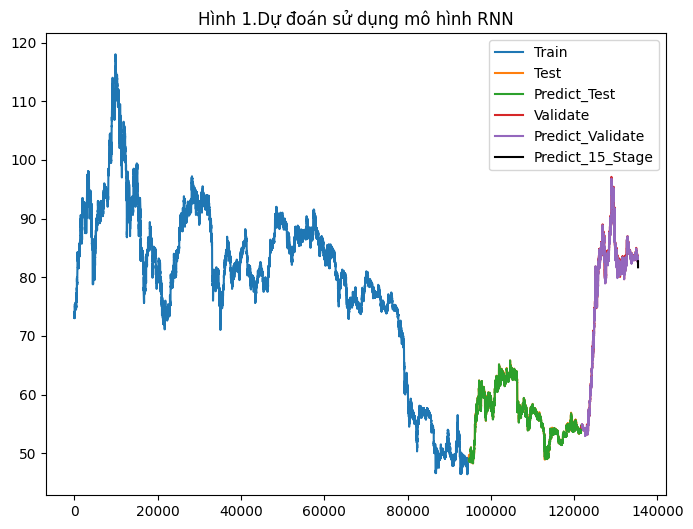

In [56]:
# Vẽ hình
plt.figure(figsize=(8, 6))
train_data_index_RNN = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data_RNN))
test_data_index_RNN = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index_RNN, scaler.inverse_transform(test_data_RNN))
test_data_index_RNN = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index_RNN,(y_pred_RNN))
val_data_index_RNN = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_RNN, scaler.inverse_transform(val_data_RNN))
val_data_index_RNN = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_RNN, y_pred_val_RNN)
predict_data_index_RNN = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_RNN, scaler.inverse_transform(lst_output_RNN), color='black')
plt.title('Hình 1.Dự đoán sử dụng mô hình RNN')
plt.legend(['Train','Test','Predict_Test','Validate','Predict_Validate','Predict_15_Stage'])
plt.show()

#### Nhận xét
- Kết quả dự báo 15 stage tiếp theo bằng mô hình RNN là pha giảm giá trị cổ phiếu.
- Độ chính xác của thuật toán dựa trên các thang đo RMSE và MAPE là rất cao.
- Độ chính xác của thuật toán để dự báo trên tập Test và Validate khoảng 99.7%.
- Nhìn trên ảnh ta thấy:
  + Kết quả dự báo trên tập Test (màu xanh) gần như trùng khớp với kết quả thực tế trên tập Test (màu vàng).
  + Kết quả dự báo trên tập Validate (màu tím) gần như trùng khớp với kết quả thực tế trên tập Validate (đỏ).
- Mô hình đang dự báo khá đúng với xu hướng giảm nhẹ của giá trị cổ phiếu, giảm 0.05 mỗi stage.


### Mô hình GRU

In [38]:
# Gọi các thư viện cần thiết để xây dựng RNN
from keras.models import Sequential
from keras.layers import Dense, GRU, BatchNormalization

In [39]:
train_data_GRU = train_data
test_data_GRU = test_data
val_data_GRU = val_data

In [40]:
# Hàm Create Dataset để chuyển đổi mảng thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [41]:
# Sử dụng hàm Create Dataset để chuyển đổi các mảng Train, Test, Validate
time_step = 100
x_train_GRU, y_train_GRU = create_dataset(train_data_GRU, time_step)
x_val_GRU, y_val_GRU = create_dataset(val_data_GRU, time_step)
x_test_GRU, y_test_GRU = create_dataset(test_data_GRU, time_step)

In [42]:
# Reshape đầu vào để phù hợp với mô hình GRU
x_train_GRU = x_train_GRU.reshape(x_train_GRU.shape[0], x_train_GRU.shape[1] , 1)
x_test_GRU = x_test_GRU.reshape(x_test_GRU.shape[0], x_test_GRU.shape[1] , 1)
x_val_GRU = x_val_GRU.reshape(x_val_GRU.shape[0], x_val_GRU.shape[1] , 1)

In [43]:
# Khai báo mô hình GRU
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# 9. Fit mô hình với dữ liệu Train
model.fit(x_train_GRU, y_train_GRU, validation_data = (x_test_GRU, y_test_GRU), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
1479/1479 [==============================] - 83s 54ms/step - loss: 4.7228e-04 - val_loss: 3.1411e-06
Epoch 2/100
1479/1479 [==============================] - 83s 56ms/step - loss: 8.9036e-06 - val_loss: 2.9130e-06
Epoch 3/100
1479/1479 [==============================] - 79s 54ms/step - loss: 9.4247e-06 - val_loss: 3.5779e-06
Epoch 4/100
1479/1479 [==============================] - 79s 53ms/step - loss: 1.0842e-05 - val_loss: 2.7880e-06
Epoch 5/100
1479/1479 [==============================] - 83s 56ms/step - loss: 1.0150e-05 - val_loss: 2.9117e-06
Epoch 6/100
1479/1479 [==============================] - 78s 53ms/step - loss: 9.7938e-06 - val_loss: 5.8085e-06
Epoch 7/100
1479/1479 [==============================] - 80s 54ms/step - loss: 1.0259e-05 - val_loss: 4.1401e-06
Epoch 8/100
1479/1479 [==============================] - 80s 54ms/step - loss: 9.5344e-06 - val_loss: 3.1054e-06
Epoch 9/100
1479/1479 [==============================] - 79s 54ms/step - loss: 9.8853e-06 - val_

In [45]:
# Dự báo dữ liệu train_predict_GRU, y_pred_GRU, y_pred_val_GRU
train_predict_GRU = model.predict(x_train_GRU)
y_pred_GRU = model.predict(x_test_GRU)
y_pred_val_GRU = model.predict(x_val_GRU)

420/420 [==============================] - 5s 11ms/step


In [46]:
# Đảo ngược giá trị thực tế của tập Test và Validate về giá trị chuẩn
train_predict_GRU = scaler.inverse_transform(train_predict_GRU)
y_pred_GRU = scaler.inverse_transform(y_pred_GRU)
y_pred_val_GRU = scaler.inverse_transform(y_pred_val_GRU)

In [47]:
# Đảo ngược giá trị thực tế của tập Test và Validate về giá trị chuẩn
real_val_GRU = scaler.inverse_transform(y_val_GRU.reshape(-1, 1))
real_test_GRU = scaler.inverse_transform(y_test_GRU.reshape(-1, 1))

In [48]:
# Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse_GRU = np.sqrt(np.mean((y_pred_GRU - real_test_GRU)**2))
val_rmse_GRU = np.sqrt(np.mean((y_pred_val_GRU - real_val_GRU)**2))
print('Testing RMSE:', test_rmse_GRU)
print('Validation RMSE:', val_rmse_GRU)

Testing RMSE: 0.1348855806474804
Validation RMSE: 0.35655054237407485


In [49]:
# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape_GRU = np.mean((np.absolute(real_test_GRU - y_pred_GRU)/real_test_GRU)*100)
val_mape_GRU = np.mean((np.absolute(real_val_GRU - y_pred_val_GRU)/real_val_GRU)*100)
print('Testing MAPE:', test_mape_GRU)
print('Validation MAPE:', val_mape_GRU)

Testing MAPE: 0.16920010147616732
Validation MAPE: 0.2667750353716251


In [50]:
# Tính phần trăm độ chính xác trên tập Test và Validate
data_range_GRU = df['Close'].max() - df['Close'].min()
test_accuracy_GRU = (1 - test_rmse_GRU / data_range_GRU) * 100
val_accuracy_GRU = (1 - val_rmse_GRU / data_range_GRU) * 100
print('Testing Accuracy (%):', test_accuracy_GRU)
print('Validation Accuracy (%):', val_accuracy_GRU)

Testing Accuracy (%): 99.81161231753146
Validation Accuracy (%): 99.50202438215912


In [52]:
# Dự báo 15 stage tiếp theo
x_input_GRU = val_data_GRU[60:].reshape(1, -1)
x_input_GRU.shape

temp_input_GRU = list(x_input_GRU)
temp_input_GRU = temp_input_GRU[0].tolist()

lst_output_GRU = []
n_steps_GRU = 13476
i = 0
while i < 15:
    if len(temp_input_GRU) > 13476:
          x_input_GRU = np.array(temp_input_GRU[1:])

          x_input_GRU = x_input_GRU.reshape(1, -1)
          x_input_GRU = x_input_GRU.reshape((1, n_steps_GRU, 1))
          yhat = model.predict(x_input_GRU, verbose=0)

          temp_input_GRU.extend(yhat[0].tolist())
          temp_input_GRU = temp_input_GRU[1:]
          lst_output_GRU.extend(yhat.tolist())
          i = i + 1
    else:
        x_input_GRU = x_input_GRU.reshape((1, n_steps_GRU, 1))
        yhat = model.predict(x_input_GRU, verbose=0)

        temp_input_GRU.extend(yhat[0].tolist())

        lst_output_GRU.extend(yhat.tolist())
        i = i + 1

# Chuẩn hóa lại dự đoán 15 stage
predicted_values_GRU = np.array(lst_output_GRU)
predicted_values_GRU = predicted_values_GRU.reshape(-1, 1)

# Chuẩn hóa dự đoán
predicted_values_GRU = scaler.inverse_transform(predicted_values_GRU)

print("Dự đoán 15 stage tiếp theo:")
print(predicted_values_GRU)

Dự đoán 15 stage tiếp theo:
[[82.71217005]
 [82.64877348]
 [82.586064  ]
 [82.52324357]
 [82.46098647]
 [82.39892569]
 [82.33700573]
 [82.27515407]
 [82.21336641]
 [82.15163851]
 [82.08997889]
 [82.02836834]
 [81.96680261]
 [81.90527529]
 [81.84377784]]


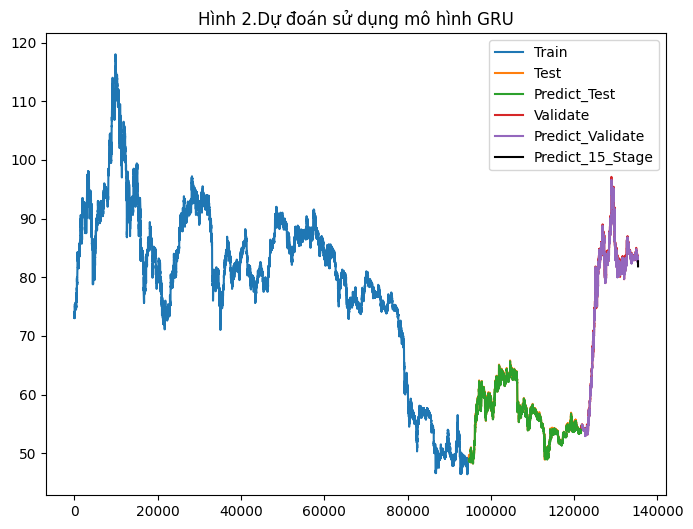

In [53]:
# Vẽ hình
plt.figure(figsize=(8, 6))
train_data_index_GRU = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data_GRU))
test_data_index_GRU = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index_GRU, scaler.inverse_transform(test_data_GRU))
test_data_index_GRU = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index_GRU, (y_pred_GRU))
val_data_index_GRU = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_GRU, scaler.inverse_transform(val_data_GRU))
val_data_index_GRU = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_GRU, y_pred_val_GRU)
predict_data_index_GRU = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_GRU, scaler.inverse_transform(lst_output_GRU), color='black')
plt.title('Hình 2.Dự đoán sử dụng mô hình GRU')
plt.legend(['Train','Test','Predict_Test','Validate','Predict_Validate','Predict_15_Stage'])
plt.show()

#### Nhận xét
- Kết quả dự báo 15 stage tiếp theo bằng mô hình GRU là pha giảm giá trị cổ phiếu.
- Độ chính xác của thuật toán dựa trên các thang đo RMSE và MAPE là rất cao.
- Độ chính xác của thuật toán để dự báo trên tập Test và Validate khoảng 99.7%.
- Nhìn trên ảnh ta thấy:
  + Kết quả dự báo trên tập Test (màu xanh) gần như trùng khớp với kết quả thực tế trên tập Test (màu vàng).
  + Kết quả dự báo trên tập Validate (màu tím) gần như trùng khớp với kết quả thực tế trên tập Validate (đỏ).
- Mô hình đang dự báo khá đúng với xu hướng giảm nhẹ của giá trị cổ phiếu, giảm 0.05 mỗi stage.


## Tổng kết

In [54]:
# So sánh 2 mô hình RNN và GRU
data = {
    'Độ đo': ['Test Accuracy (%)', 'Validation Accuracy (%)', 'Test RMSE', 'Validation RMSE', 'Test MAPE', 'Validation MAPE'],
    'Mô hình RNN': [test_accuracy_RNN, val_accuracy_RNN, test_rmse_RNN, val_rmse_RNN, test_mape_RNN, val_mape_RNN],
    'Mô hình GRU': [test_accuracy_GRU, val_accuracy_GRU, test_rmse_GRU, val_rmse_GRU, test_mape_GRU, val_mape_GRU]
}

df = pd.DataFrame(data).set_index('Độ đo')

print(df)

                         Mô hình RNN  Mô hình GRU
Độ đo                                            
Test Accuracy (%)          99.827688    99.811612
Validation Accuracy (%)    99.495334    99.502024
Test RMSE                   0.123375     0.134886
Validation RMSE             0.361341     0.356551
Test MAPE                   0.136705     0.169200
Validation MAPE             0.260290     0.266775


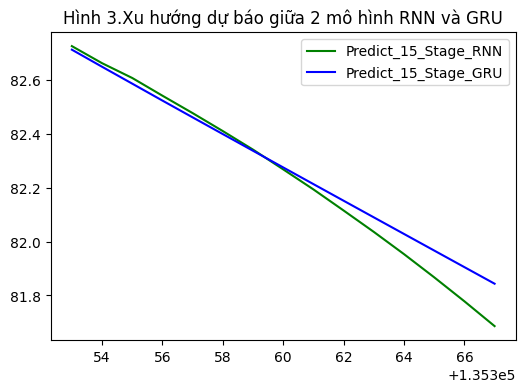

In [55]:
# Nhận xét Predict 15 stage của 2 mô hình
plt.figure(figsize=(6, 4))
predict_data_index_RNN = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_RNN, scaler.inverse_transform(lst_output_RNN), color='green')
predict_data_index_GRU = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_GRU, scaler.inverse_transform(lst_output_GRU), color='blue')
plt.title('Hình 3.Xu hướng dự báo giữa 2 mô hình RNN và GRU')
plt.legend(['Predict_15_Stage_RNN', 'Predict_15_Stage_GRU'])
plt.show()

### Tổng kết
- Nhìn ảnh so sánh trên, ta thấy cả 2 mô hình có kết dự đoán khá đúng so với xu hướng giảm của cổ phiếu.
- Tuy nhiên ta thấy, dự đoán xu hướng giảm của mô hình GRU chính xác hơn, khi các stage có xu hướng giảm tương đối nhẹ, còn dự đoán của RNN có xu hướng giảm hơn.
